In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import os
import sys

print("✓ Libraries imported")
print(f"PyTorch version: {torch.__version__}")
print(f"Available device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")

✓ Librerie importate
PyTorch version: 2.7.1+cu118
Device disponibile: cuda


## 2. DATA LOADING

In [ ]:
# Read the Parquet file OVEN
Oven = pd.read_parquet("datasets_by_subject/Warmtepomp-Sturing.parquet")
Oven['_time'] = pd.to_datetime(Oven['_time'])
Oven = Oven.sort_values('_time').reset_index(drop=True)
print(f"Oven loaded: {Oven.shape[0]} rows, {Oven.shape[1]} columns")
Oven.head()

Oven caricato: 35037 righe, 12 colonne


,_time,_measurement,_field,_value,building,device_ID,msr_ID,msr_category,msr_device,msr_extra,msr_spec,msr_subject
0,2024-10-20 02:15:00,Electricity,kW,-0.007910,Household_1_JVR,33a8340b-f03c-4851-9f9f-99b98e2c4cc9,100000029,Power_active,Smappee,L2,Consumption_Production,Warmtepomp - Sturing
1,2024-10-20 02:30:00,Electricity,kW,-0.007956,Household_1_JVR,33a8340b-f03c-4851-9f9f-99b98e2c4cc9,100000029,Power_active,Smappee,L2,Consumption_Production,Warmtepomp - Sturing
2,2024-10-20 02:45:00,Electricity,kW,-0.007950,Household_1_JVR,33a8340b-f03c-4851-9f9f-99b98e2c4cc9,100000029,Power_active,Smappee,L2,Consumption_Production,Warmtepomp - Sturing
3,2024-10-20 03:00:00,Electricity,kW,-0.007968,Household_1_JVR,33a8340b-f03c-4851-9f9f-99b98e2c4cc9,100000029,Power_active,Smappee,L2,Consumption_Production,Warmtepomp - Sturing
4,2024-10-20 03:15:00,Electricity,kW,-0.007880,Household_1_JVR,33a8340b-f03c-4851-9f9f-99b98e2c4cc9,100000029,Power_active,Smappee,L2,Consumption_Production,Warmtepomp - Sturing


In [ ]:
# Load BUILDING (extract from main dataset if necessary)
building_path = "datasets_by_subject/Building.parquet"

if not os.path.exists(building_path):
    print("Extracting Building from main dataset...")
    df_main = pd.read_parquet("influxdb_query_20251020_074134.parquet")
    Building = df_main[df_main['msr_subject'] == 'Building'].copy()
    Building = Building.sort_values('_time').reset_index(drop=True)
    Building.to_parquet(building_path, compression='snappy', engine='fastparquet')
    print(f"✓ Building saved to {building_path}")
else:
    Building = pd.read_parquet(building_path)
    Building['_time'] = pd.to_datetime(Building['_time'])

print(f"Building loaded: {Building.shape[0]} rows, {Building.shape[1]} columns")
Building.head()

Building caricato: 140148 righe, 12 colonne


,_time,_measurement,_field,_value,building,device_ID,msr_ID,msr_category,msr_device,msr_extra,msr_spec,msr_subject
index,,,,,,,,,,,,
420440,2024-10-20 02:15:00,Electricity,kW,0.198563,Household_1_JVR,33a8340b-f03c-4851-9f9f-99b98e2c4cc9,100000038,Power_active,Smappee,Total,Consumption,Building
420441,2024-10-20 02:30:00,Electricity,kW,0.228958,Household_1_JVR,33a8340b-f03c-4851-9f9f-99b98e2c4cc9,100000038,Power_active,Smappee,Total,Consumption,Building
420442,2024-10-20 02:45:00,Electricity,kW,0.216411,Household_1_JVR,33a8340b-f03c-4851-9f9f-99b98e2c4cc9,100000038,Power_active,Smappee,Total,Consumption,Building
420443,2024-10-20 03:00:00,Electricity,kW,0.170043,Household_1_JVR,33a8340b-f03c-4851-9f9f-99b98e2c4cc9,100000038,Power_active,Smappee,Total,Consumption,Building
420444,2024-10-20 03:15:00,Electricity,kW,0.180233,Household_1_JVR,33a8340b-f03c-4851-9f9f-99b98e2c4cc9,100000038,Power_active,Smappee,Total,Consumption,Building


## 3. EXPLORATORY DATA ANALYSIS

In [ ]:
# Analyze OVEN
time_diff = Oven['_time'].diff()
total_duration = Oven['_time'].max() - Oven['_time'].min()

print("=== OVEN ===")
print(f"Minimum interval: {time_diff.min()}")
print(f"Maximum interval: {time_diff.max()}")
print(f"Average interval: {time_diff.mean()}")
print(f"Total duration: {total_duration.days} days")
print(f"Rows per day: {len(Oven) / total_duration.days:.0f}")

# Calculate sequences for 1 day
rows_for_1_day = int((len(Oven) / total_duration.days) * 1)
print(f"Rows for 1 day: {rows_for_1_day}")

=== OVEN ===
Intervallo minimo: 0 days 00:00:00
Intervallo massimo: 0 days 01:15:00
Intervallo medio: 0 days 00:15:00.077063591
Durata totale: 364 giorni
Righe per giorno: 96
Righe per 1 giorno: 96


In [ ]:
# Analyze BUILDING
time_diff_building = Building['_time'].diff()
total_duration_building = Building['_time'].max() - Building['_time'].min()

print("=== BUILDING ===")
print(f"Minimum interval: {time_diff_building.min()}")
print(f"Maximum interval: {time_diff_building.max()}")
print(f"Average interval: {time_diff_building.mean()}")
print(f"Total duration: {total_duration_building.days} days")
print(f"Rows per day: {len(Building) / total_duration_building.days:.0f}")

rows_for_1_day_building = int((len(Building) / total_duration_building.days) * 1)
print(f"Rows for 1 day: {rows_for_1_day_building}")

# Use the minimum
window_size = min(rows_for_1_day, rows_for_1_day_building)
print(f"\nChosen window size: {window_size} (~1 day sequence)")

=== BUILDING ===
Intervallo minimo: -365 days +00:15:00
Intervallo massimo: 0 days 01:15:00
Intervallo medio: 0 days 00:03:45.014449114
Durata totale: 364 giorni
Righe per giorno: 385
Righe per 1 giorno: 385

Window size scelto: 96 (sequenza di ~1 giorno)


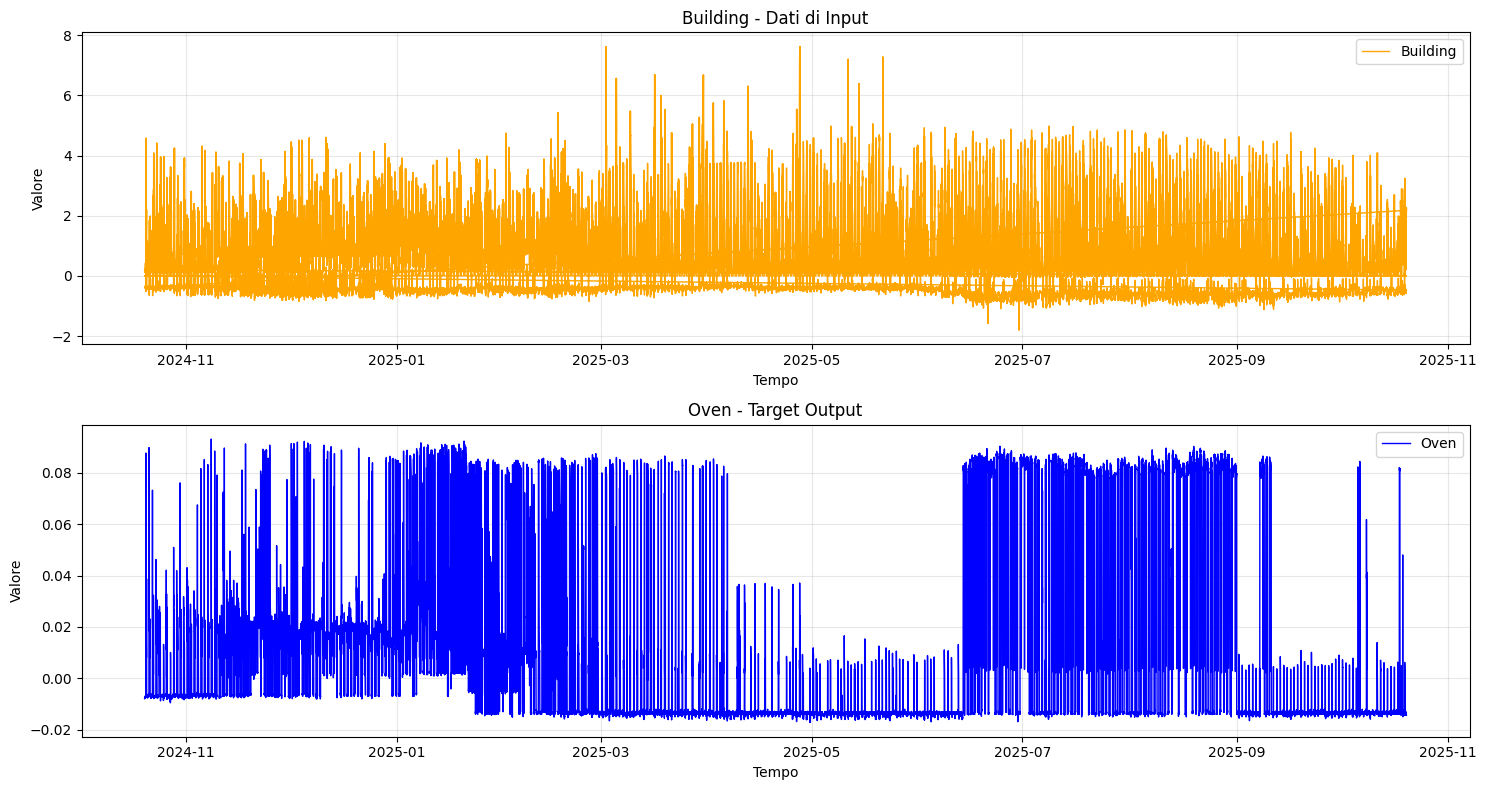

In [ ]:
# Visualize complete timelines
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

axes[0].plot(Building['_time'], Building['_value'], linewidth=1, color='orange', label='Building')
axes[0].set_title('Building - Input Data')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Value')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

axes[1].plot(Oven['_time'], Oven['_value'], linewidth=1, color='blue', label='Oven')
axes[1].set_title('Oven - Target Output')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Value')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

## 4. SEQUENCE-TO-POINT DATA CREATION

**Difference from Seq2Seq:**
- Seq2Seq: Input sequence → Output sequence (same length)
- Seq2Point: Input sequence → Single output value (center point of the target window)

In [ ]:
def create_seq2point_data(df_input, df_target, seq_length, target_position='middle'):
    """
    Create data for Seq2Point:
    - Input: sequence of length seq_length
    - Target: single value (middle, last, or specific index)
    
    Args:
        df_input: DataFrame with input data (Building)
        df_target: DataFrame with target data (Oven)
        seq_length: length of the input sequence
        target_position: 'middle', 'last', or integer index
    
    Returns:
        input_sequences: array (N, seq_length, 1)
        target_points: array (N, 1)
        timestamps: list of target point timestamps
    """
    input_sequences = []
    target_points = []
    timestamps = []
    
    # Determine the target position
    if target_position == 'middle':
        target_idx = seq_length // 2
    elif target_position == 'last':
        target_idx = seq_length - 1
    else:
        target_idx = int(target_position)
    
    # Limit to the minimum between the two datasets
    max_idx = min(len(df_input), len(df_target)) - seq_length
    
    for i in range(max_idx):
        # Input sequence
        input_seq = df_input.iloc[i:i+seq_length]['_value'].values
        
        # Single target point (at the center of the window)
        target_point = df_target.iloc[i + target_idx]['_value']
        target_time = df_target.iloc[i + target_idx]['_time']
        
        input_sequences.append(input_seq.reshape(-1, 1))
        target_points.append(target_point)
        timestamps.append(target_time)
    
    return np.array(input_sequences), np.array(target_points).reshape(-1, 1), timestamps

print("✓ Function create_seq2point_data defined")

✓ Funzione create_seq2point_data definita


In [ ]:
# Create Seq2Point data
print(f"Creating Seq2Point data with window_size={window_size}...")
print(f"Target position: middle (index {window_size // 2})")

X_seq2point, y_seq2point, timestamps = create_seq2point_data(
    Building, Oven, 
    seq_length=window_size, 
    target_position='middle'
)

print(f"\n✓ Input sequences shape: {X_seq2point.shape}")
print(f"✓ Target points shape: {y_seq2point.shape}")
print(f"✓ Total samples: {len(X_seq2point):,}")

Creazione dati Seq2Point con window_size=96...
Target position: middle (indice 48)

✓ Input sequences shape: (34941, 96, 1)
✓ Target points shape: (34941, 1)
✓ Campioni totali: 34,941


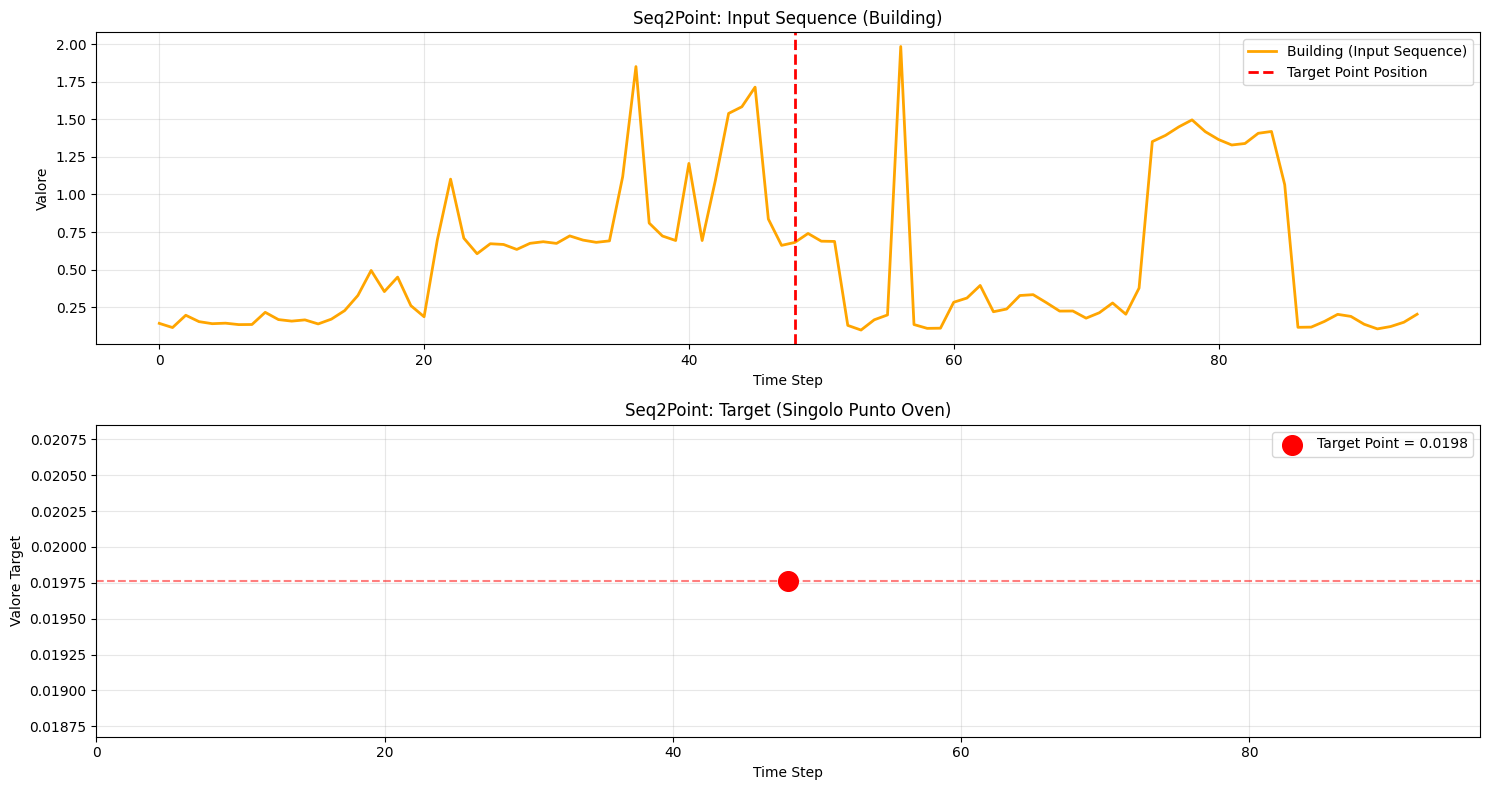


Esempio 100:
  Input: sequenza di 96 valori Building
  Target: singolo valore Oven = 0.019764


In [ ]:
# Visualizza esempio Seq2Point
sample_idx = 100
mid_point = window_size // 2

fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# Input sequence
axes[0].plot(range(window_size), X_seq2point[sample_idx].flatten(), 
             linewidth=2, color='orange', label='Building (Input Sequence)')
axes[0].axvline(x=mid_point, color='red', linestyle='--', linewidth=2, label='Target Point Position')
axes[0].set_title('Seq2Point: Input Sequence (Building)')
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('Value')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Target point
axes[1].scatter([mid_point], [y_seq2point[sample_idx]], s=200, c='red', zorder=5, label=f'Target Point = {y_seq2point[sample_idx][0]:.4f}')
axes[1].axhline(y=y_seq2point[sample_idx][0], color='red', linestyle='--', alpha=0.5)
axes[1].set_title('Seq2Point: Target (Single Oven Point)')
axes[1].set_xlabel('Time Step')
axes[1].set_ylabel('Target Value')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim(0, window_size)

plt.tight_layout()
plt.show()

print(f"\nExample {sample_idx}:")
print(f"  Input: sequence of {window_size} Building values")
print(f"  Target: single Oven value = {y_seq2point[sample_idx][0]:.6f}")

## 5. MODEL DEFINITION - CNN Seq2Point

In [ ]:
class CNN2DSeq2Point(nn.Module):
    """
    CNN 2D per Seq2Point prediction.
    Input: (batch, seq_len, 1) - sequenza temporale
    Output: (batch, 1) - singolo valore predetto
    """
    def __init__(self, seq_length, hidden_channels=64, num_layers=4):
        super(CNN2DSeq2Point, self).__init__()
        
        # Encoder CNN layers
        encoder_layers = []
        in_channels = 1
        
        for i in range(num_layers):
            encoder_layers.extend([
                nn.Conv2d(in_channels, hidden_channels, kernel_size=(1, 3), padding=(0, 1)),
                nn.BatchNorm2d(hidden_channels),
                nn.ReLU(),
                nn.Dropout2d(0.1)
            ])
            in_channels = hidden_channels
        
        self.encoder = nn.Sequential(*encoder_layers)
        
        # Global Average Pooling + FC layers per output singolo
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_channels, hidden_channels // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_channels // 2, 1)
        )
        
    def forward(self, x):
        # x: (batch, seq_len, 1) -> (batch, 1, 1, seq_len)
        x = x.transpose(1, 2).unsqueeze(2)
        
        # Encoder
        features = self.encoder(x)
        
        # Global pooling -> single value
        pooled = self.global_pool(features)
        
        # FC -> output
        output = self.fc(pooled)
        
        return output


print("✓ CNN2D Seq2Point Model defined")
print("  - Input: sequence (batch, seq_len, 1)")
print("  - Output: single value (batch, 1)")

✓ Modello CNN2D Seq2Point definito
  - Input: sequenza (batch, seq_len, 1)
  - Output: singolo valore (batch, 1)


## 6. DATA PREPARATION FOR TRAINING

In [ ]:
class Seq2PointDataset(Dataset):
    """
    Dataset for Seq2Point:
    - input: sequence (seq_len, 1)
    - target: single value (1,)
    """
    def __init__(self, input_sequences, target_points):
        self.input_sequences = torch.FloatTensor(input_sequences)
        self.target_points = torch.FloatTensor(target_points)
    
    def __len__(self):
        return len(self.input_sequences)
    
    def __getitem__(self, idx):
        return self.input_sequences[idx], self.target_points[idx]

print("✓ Seq2PointDataset defined")

✓ Seq2PointDataset definito


## 7. TRAINING

In [ ]:
# ===== CNN 2D Seq2Point CONFIGURATION =====

batch_size = 512          # Larger batches (small output)
sequence_step = 3         # Sequence sampling
hidden_channels = 128     # CNN channels
num_layers = 5            # CNN layers
num_epochs = 100          # Epochs
learning_rate = 0.001     # Learning rate

# Apply step to the data
X_sampled = X_seq2point[::sequence_step]
y_sampled = y_seq2point[::sequence_step]

# Train/Val split (80/20)
split_idx = int(len(X_sampled) * 0.8)
X_train, X_val = X_sampled[:split_idx], X_sampled[split_idx:]
y_train, y_val = y_sampled[:split_idx], y_sampled[split_idx:]

# Create dataset and dataloader
train_dataset = Seq2PointDataset(X_train, y_train)
val_dataset = Seq2PointDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

print("=" * 60)
print("CNN 2D Seq2Point CONFIGURATION")
print("=" * 60)
print(f"Train samples: {len(X_train):,} | Val samples: {len(X_val):,}")
print(f"Batch size: {batch_size} | Train batches: {len(train_loader)} | Val batches: {len(val_loader)}")
print(f"Model: CNN 2D with {num_layers} layers, {hidden_channels} channels")
print(f"Device: {'GPU 🚀' if torch.cuda.is_available() else 'CPU'}")
print("=" * 60)

# Setup device and model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN2DSeq2Point(seq_length=window_size, hidden_channels=hidden_channels, num_layers=num_layers).to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"\n✓ CNN 2D Seq2Point Model: {total_params:,} parameters")

# Loss function per Seq2Point
class ZeroAwareL1Loss(nn.Module):
    """
    Loss that penalizes when target is zero but prediction is not.
    Uses L1 (MAE) which is more robust for single values.
    """
    def __init__(self, zero_threshold=0.01, penalty_factor=30.0):
        super(ZeroAwareL1Loss, self).__init__()
        self.zero_threshold = zero_threshold
        self.penalty_factor = penalty_factor
    
    def forward(self, predictions, targets):
        abs_error = torch.abs(predictions - targets)
        
        # Penalize when target ≈ 0 but prediction ≠ 0
        should_be_zero = torch.abs(targets) < self.zero_threshold
        pred_not_zero = torch.abs(predictions) >= self.zero_threshold
        
        weights = torch.ones_like(targets)
        penalty_mask = should_be_zero & pred_not_zero
        weights[penalty_mask] = self.penalty_factor
        
        return (abs_error * weights).mean()

criterion = ZeroAwareL1Loss(zero_threshold=0.01, penalty_factor=50.0)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

print("✓ Loss, optimizer and scheduler configured")

CONFIGURAZIONE CNN 2D Seq2Point
Train samples: 9,317 | Val samples: 2,330
Batch size: 512 | Train batches: 19 | Val batches: 5
Modello: CNN 2D con 5 layer, 128 canali
Device: GPU 🚀

✓ Modello CNN 2D Seq2Point: 207,233 parametri
✓ Loss, optimizer e scheduler configurati


In [ ]:
import time

def train_epoch(model, iterator, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    
    for input_seq, target_point in iterator:
        input_seq = input_seq.to(device)
        target_point = target_point.to(device)
        
        output = model(input_seq)
        loss = criterion(output, target_point)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        epoch_loss += loss.item()
    
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion, device):
    model.eval()
    epoch_loss = 0
    
    with torch.no_grad():
        for input_seq, target_point in iterator:
            input_seq = input_seq.to(device)
            target_point = target_point.to(device)
            
            output = model(input_seq)
            loss = criterion(output, target_point)
            epoch_loss += loss.item()
    
    return epoch_loss / len(iterator)

# Training loop
train_losses = []
val_losses = []
best_val_loss = float('inf')

print(f"\n🚀 Starting CNN 2D Seq2Point training ({num_epochs} epochs)...\n")

start_total = time.time()
for epoch in range(num_epochs):
    start_epoch = time.time()
    
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss = evaluate(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_seq2point_model.pth')
    
    elapsed = time.time() - start_epoch
    
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}/{num_epochs} | Train: {train_loss:.6f} | Val: {val_loss:.6f} | Time: {elapsed:.1f}s")

total_time = time.time() - start_total
print(f"\n✓ Training completed in {total_time/60:.1f} minutes!")
print(f"✓ Best validation loss: {best_val_loss:.6f}")


🚀 Inizio training CNN 2D Seq2Point (100 epoche)...

Epoch   1/100 | Train: 0.321584 | Val: 0.073646 | Time: 1.7s
Epoch  10/100 | Train: 0.023943 | Val: 0.028991 | Time: 1.1s
Epoch  20/100 | Train: 0.023013 | Val: 0.028640 | Time: 1.1s
Epoch  30/100 | Train: 0.022668 | Val: 0.028732 | Time: 1.1s
Epoch  40/100 | Train: 0.022756 | Val: 0.028830 | Time: 1.1s
Epoch  50/100 | Train: 0.023372 | Val: 0.029444 | Time: 1.6s
Epoch  60/100 | Train: 0.022486 | Val: 0.028902 | Time: 1.1s
Epoch  70/100 | Train: 0.023084 | Val: 0.029407 | Time: 1.2s
Epoch  80/100 | Train: 0.023498 | Val: 0.029070 | Time: 1.1s
Epoch  90/100 | Train: 0.022796 | Val: 0.029124 | Time: 1.2s
Epoch 100/100 | Train: 0.023230 | Val: 0.029193 | Time: 1.2s

✓ Training completato in 1.9 minuti!
✓ Best validation loss: 0.027887


## 8. RESULTS & VISUALIZATION

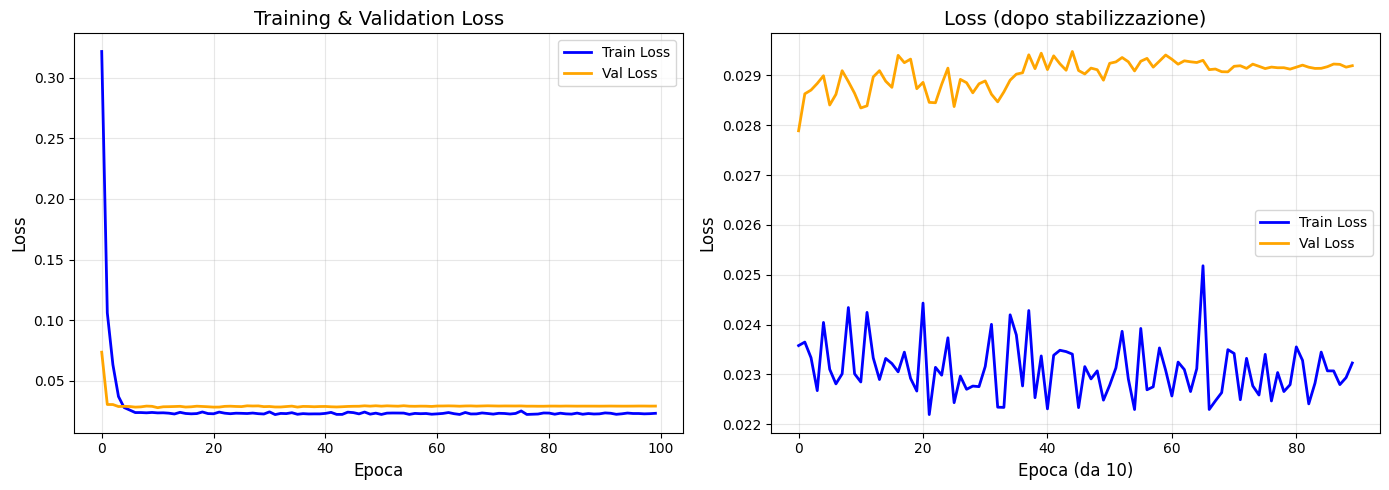

Loss iniziale - Train: 0.321584 | Val: 0.073646
Loss finale   - Train: 0.023230 | Val: 0.029193


In [ ]:
# Plot della loss durante il training
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(train_losses, linewidth=2, color='blue', label='Train Loss')
axes[0].plot(val_losses, linewidth=2, color='orange', label='Val Loss')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training & Validation Loss', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(train_losses[10:], linewidth=2, color='blue', label='Train Loss')
axes[1].plot(val_losses[10:], linewidth=2, color='orange', label='Val Loss')
axes[1].set_xlabel('Epoch (from 10)', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Loss (after stabilization)', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Initial loss - Train: {train_losses[0]:.6f} | Val: {val_losses[0]:.6f}")
print(f"Final loss   - Train: {train_losses[-1]:.6f} | Val: {val_losses[-1]:.6f}")

In [ ]:
# Save the final model
model_path = "seq2point_cnn2d_energy_model.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'hyperparameters': {
        'hidden_channels': hidden_channels,
        'num_layers': num_layers,
        'window_size': window_size,
        'seq_length': window_size
    },
    'train_losses': train_losses,
    'val_losses': val_losses,
    'best_val_loss': best_val_loss
}, model_path)
print(f"✓ CNN 2D Seq2Point Model saved: {model_path}")

✓ Modello CNN 2D Seq2Point salvato: seq2point_cnn2d_energy_model.pth


## 9. INFERENCE & EVALUATION

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the best model
model.load_state_dict(torch.load('best_seq2point_model.pth', weights_only=True))

# Predictions on validation set
model.eval()
all_predictions = []
all_targets = []

with torch.no_grad():
    for input_seq, target_point in val_loader:
        input_seq = input_seq.to(device)
        predictions = model(input_seq)
        
        all_predictions.extend(predictions.cpu().numpy().flatten())
        all_targets.extend(target_point.numpy().flatten())

all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

# Metrics
mse = mean_squared_error(all_targets, all_predictions)
mae = mean_absolute_error(all_targets, all_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(all_targets, all_predictions)

print("=" * 50)
print("VALIDATION SET METRICS")
print("=" * 50)
print(f"MSE:  {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"MAE:  {mae:.6f}")
print(f"R²:   {r2:.6f}")
print("=" * 50)

METRICHE SUL VALIDATION SET
MSE:  0.001854
RMSE: 0.043055
MAE:  0.029532
R²:   -0.081401


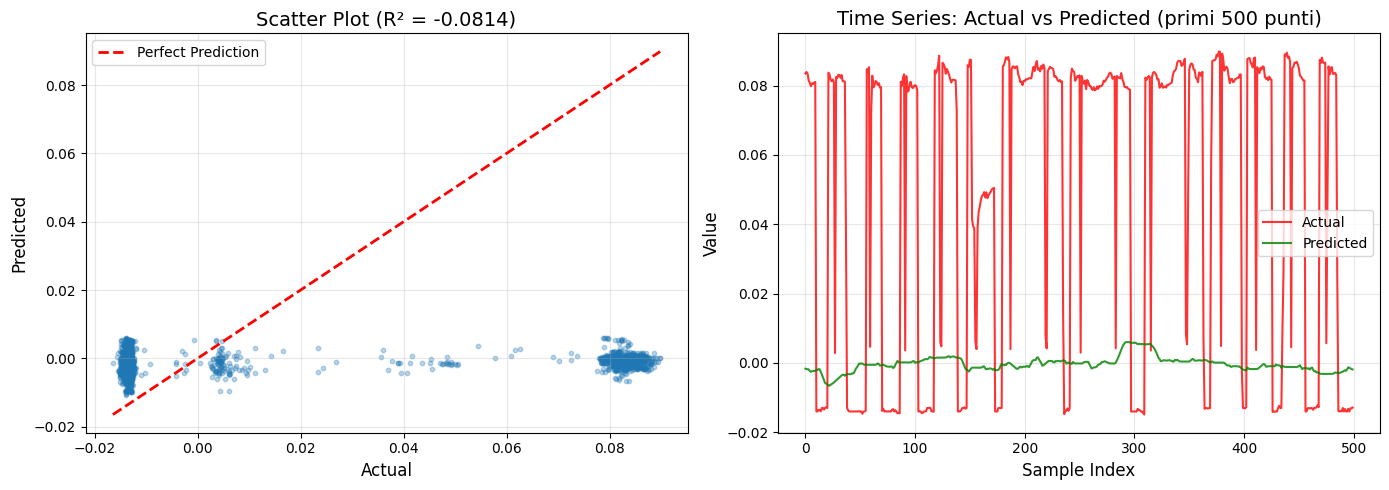

In [ ]:
# Visualize predictions vs actual (scatter plot)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
axes[0].scatter(all_targets, all_predictions, alpha=0.3, s=10)
axes[0].plot([all_targets.min(), all_targets.max()], 
             [all_targets.min(), all_targets.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual', fontsize=12)
axes[0].set_ylabel('Predicted', fontsize=12)
axes[0].set_title(f'Scatter Plot (R² = {r2:.4f})', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Time series comparison (subset)
n_points = 500
axes[1].plot(range(n_points), all_targets[:n_points], linewidth=1.5, color='red', label='Actual', alpha=0.8)
axes[1].plot(range(n_points), all_predictions[:n_points], linewidth=1.5, color='green', label='Predicted', alpha=0.8)
axes[1].set_xlabel('Sample Index', fontsize=12)
axes[1].set_ylabel('Value', fontsize=12)
axes[1].set_title(f'Time Series: Actual vs Predicted (first {n_points} points)', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Error analysis on zero values
zero_mask = np.abs(all_targets) < 0.01
nonzero_mask = ~zero_mask

print("\n=== ANALYSIS FOR ZERO vs NON-ZERO VALUES ===")
print(f"\nSamples with target ≈ 0: {zero_mask.sum()} ({100*zero_mask.mean():.1f}%)")
print(f"Samples with target ≠ 0: {nonzero_mask.sum()} ({100*nonzero_mask.mean():.1f}%)")

if zero_mask.sum() > 0:
    mae_zero = mean_absolute_error(all_targets[zero_mask], all_predictions[zero_mask])
    print(f"\nMAE on zero values: {mae_zero:.6f}")
    print(f"Mean predictions when target=0: {all_predictions[zero_mask].mean():.6f}")

if nonzero_mask.sum() > 0:
    mae_nonzero = mean_absolute_error(all_targets[nonzero_mask], all_predictions[nonzero_mask])
    print(f"\nMAE on non-zero values: {mae_nonzero:.6f}")


=== ANALISI PER VALORI ZERO vs NON-ZERO ===

Campioni con target ≈ 0: 103 (4.4%)
Campioni con target ≠ 0: 2227 (95.6%)

MAE su valori zero: 0.006457
Media predizioni quando target=0: -0.001677

MAE su valori non-zero: 0.030599


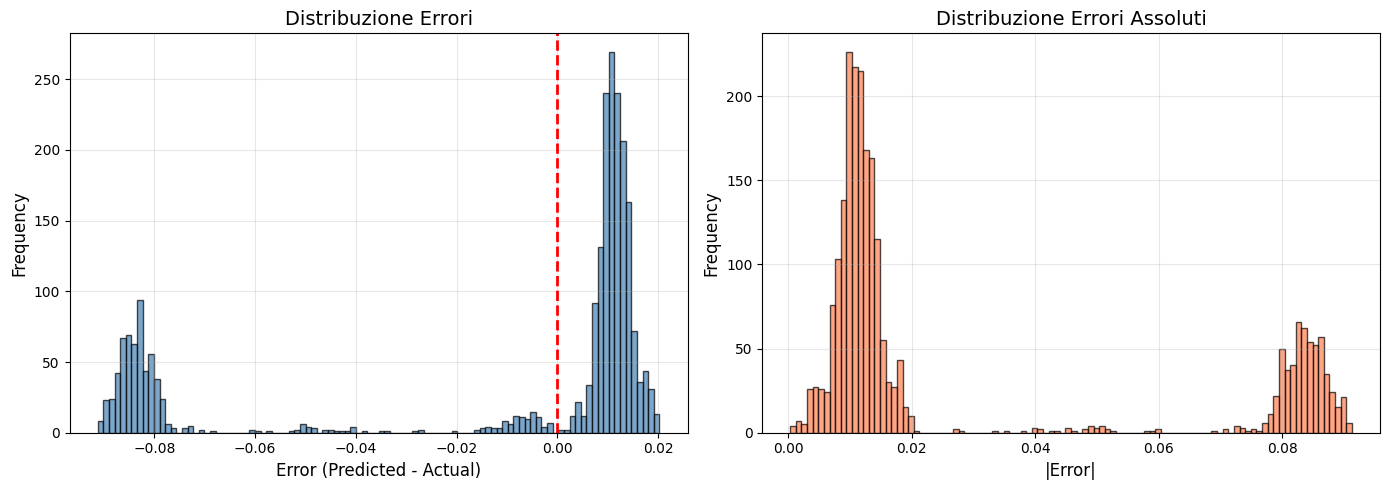


Statistiche errori:
  Media: -0.013603
  Std:   0.040850
  Min:   -0.091239
  Max:   0.020273


In [ ]:
# Error distribution
errors = all_predictions - all_targets

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(errors, bins=100, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Error (Predicted - Actual)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Error Distribution', fontsize=14)
axes[0].grid(True, alpha=0.3)

axes[1].hist(np.abs(errors), bins=100, color='coral', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('|Error|', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Absolute Error Distribution', fontsize=14)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nError statistics:")
print(f"  Mean: {errors.mean():.6f}")
print(f"  Std:   {errors.std():.6f}")
print(f"  Min:   {errors.min():.6f}")
print(f"  Max:   {errors.max():.6f}")